# Modelling of France Accidents

**Cohort:** mar23_accidents

**Author:** Tiago Russomanno

**Date:** 23 October 2023

### Radon forester with target variable severe



## Loading of required libraries

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


## Importing the data

In [2]:
df = pd.read_csv('./data/231030_clean_table_for_analysis.csv', low_memory = False, index_col = 0)

## Data description
### Data

In [3]:
df.head()

,place,catu,grav,sexe,an_nais,trajet,locp,an,mois,jour,...,manv,date,is_holiday,holiday,datetime,actp,num_veh,etatp,day_of_week,hour_of_day
Num_Acc,,,,,,,,,,,,,,,,,,,,,
201900000001,2.0,2,4,2,2002,0.0,-1.0,2019,11,30,...,23.0,2019-11-30,False,NaN,2019-11-30 01:30:00,0,14,0,5,1
201900000001,1.0,1,4,2,1993,5.0,-1.0,2019,11,30,...,23.0,2019-11-30,False,NaN,2019-11-30 01:30:00,0,14,0,5,1
201900000001,1.0,1,1,1,1959,0.0,-1.0,2019,11,30,...,11.0,2019-11-30,False,NaN,2019-11-30 01:30:00,0,0,0,5,1
201900000002,1.0,1,4,2,1994,0.0,-1.0,2019,11,30,...,0.0,2019-11-30,False,NaN,2019-11-30 02:50:00,0,0,0,5,2
201900000003,1.0,1,1,1,1996,0.0,-1.0,2019,11,28,...,2.0,2019-11-28,False,NaN,2019-11-28 15:15:00,1,0,0,3,15


### Data types

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2421684 entries, 201900000001 to 201800055766
Data columns (total 42 columns):
 #   Column       Dtype  
---  ------       -----  
 0   place        float64
 1   catu         int64  
 2   grav         int64  
 3   sexe         int64  
 4   an_nais      int64  
 5   trajet       float64
 6   locp         float64
 7   an           int64  
 8   mois         int64  
 9   jour         int64  
 10  hrmn         object 
 11  lum          int64  
 12  agg          int64  
 13  int          int64  
 14  atm          float64
 15  col          float64
 16  dep          int64  
 17  catr         float64
 18  circ         float64
 19  nbv          float64
 20  vosp         float64
 21  prof         float64
 22  plan         float64
 23  surf         float64
 24  infra        float64
 25  situ         float64
 26  senc         float64
 27  catv         int64  
 28  occutc       float64
 29  obs          float64
 30  obsm         float64
 31  choc    

### Missing data

In [5]:
df.isna().sum()

place                0
catu                 0
grav                 0
sexe                 0
an_nais              0
trajet               0
locp                 0
an                   0
mois                 0
jour                 0
hrmn                 0
lum                  0
agg                  0
int                  0
atm                  0
col                  0
dep                  0
catr                 0
circ                 0
nbv                  0
vosp                 0
prof                 0
plan                 0
surf                 0
infra                0
situ                 0
senc                 0
catv                 0
occutc               0
obs                  0
obsm                 0
choc                 0
manv                 0
date                 0
is_holiday           0
holiday        2367768
datetime             0
actp                 0
num_veh              0
etatp                0
day_of_week          0
hour_of_day          0
dtype: int64

This data has no missing values, accept the `holiday` variable which contains the name of the holiday or NaN.

### Drop variables
The dataset contains still some variables that represent information represented by other variables or are a finer granulation. The latter might be added later, if the primary variable is relevant.

- `holiday`: classifies the holiday, but will be used only, if `is_holiday` is relevant

In [6]:
columns_drop = ['holiday', 'hrmn', 'datetime']

df.drop(columns = columns_drop, inplace = True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2421684 entries, 201900000001 to 201800055766
Data columns (total 39 columns):
 #   Column       Dtype  
---  ------       -----  
 0   place        float64
 1   catu         int64  
 2   grav         int64  
 3   sexe         int64  
 4   an_nais      int64  
 5   trajet       float64
 6   locp         float64
 7   an           int64  
 8   mois         int64  
 9   jour         int64  
 10  lum          int64  
 11  agg          int64  
 12  int          int64  
 13  atm          float64
 14  col          float64
 15  dep          int64  
 16  catr         float64
 17  circ         float64
 18  nbv          float64
 19  vosp         float64
 20  prof         float64
 21  plan         float64
 22  surf         float64
 23  infra        float64
 24  situ         float64
 25  senc         float64
 26  catv         int64  
 27  occutc       float64
 28  obs          float64
 29  obsm         float64
 30  choc         float64
 31  manv    

## Data preparation
### Transform data types
#### Date and time variables
The date and time variables are maybe important as grouping variables or as contrains for time dependent severity of accidents.

_Problem_:

Due to the export to `csv`, the `datatime` data time is lost and thus, it is required to assign it again.

**Steps:**
1. Transform `date` and `hrmn` to `datetime` type.nais` to integer and `date` to `date`.

In [8]:
df = df.assign(date = pd.to_datetime(df['date']))
df['date'] = df.apply(lambda x: int(x['date'].timestamp()), axis = 1)

In [8]:
# Fixing the hrmn issue: old version 
# Transform `date`
#df = df.assign(date = pd.to_datetime(df['date']))
#df = df.assign(hrmn = pd.to_datetime(df['hrmn']))
#df['date'] = df.apply(lambda x: int(x['date'].timestamp()), axis = 1)
#df['hrmn'] = df.apply(lambda x: int(x['hrmn'].timestamp()), axis = 1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2421684 entries, 201900000001 to 201800055766
Data columns (total 39 columns):
 #   Column       Dtype  
---  ------       -----  
 0   place        float64
 1   catu         int64  
 2   grav         int64  
 3   sexe         int64  
 4   an_nais      int64  
 5   trajet       float64
 6   locp         float64
 7   an           int64  
 8   mois         int64  
 9   jour         int64  
 10  lum          int64  
 11  agg          int64  
 12  int          int64  
 13  atm          float64
 14  col          float64
 15  dep          int64  
 16  catr         float64
 17  circ         float64
 18  nbv          float64
 19  vosp         float64
 20  prof         float64
 21  plan         float64
 22  surf         float64
 23  infra        float64
 24  situ         float64
 25  senc         float64
 26  catv         int64  
 27  occutc       float64
 28  obs          float64
 29  obsm         float64
 30  choc         float64
 31  manv    

#### Aggregation and encoding of the target variable
In the previous notebook, we used the `grav` variable as is without any further processing. The modelling result was not satisfying. Therefore, it was decided to aggregate the four classes into two classes "severe" and "non-severe" encoded in `[1,0]`.

In [10]:
df.grav.unique()

array([4, 1, 2, 3], dtype=int64)

In [11]:
# Encoding
# grav encodes in 1=unscathed, 2=light injured, 3=hospitalized, 4=killed.
# Thus [1,2] = 0, [3,4] = 1

df['severe'] = np.where(df['grav'].isin([1, 2]), 0, 1)

In [11]:
# Encoding old enconding
#df['severe'] = np.where(df['grav'].isin([0, 1]), 0, 1)

In [12]:
df.severe.unique()

array([1, 0])

The following visualisation shows the balance between the two classes. The dataset is much more balanced now compared to the four classes `grav`.

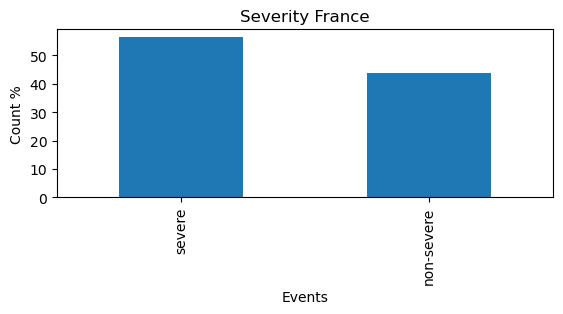

In [13]:
# checking the variables graphically and their distribution
import matplotlib.pyplot as plt
# exploring severe cases in % 
event_counts = df['severe'].value_counts()
event_percentages = (event_counts / event_counts.sum()) * 100
plt.subplot(2,1,1)
event_percentages.plot.bar()
labels = ['severe','non-severe']
# Add labels and title to the plot
plt.xticks(range(len(event_counts)), labels)
plt.xlabel('Events')
plt.ylabel('Count %')
plt.title('Severity France')
# Display the plot
plt.show()

## Data analysis
### Correlation matrix
To get a first glimpse on the possible contrains in the data, a correlation matrix is plotted.

In [14]:
# Sort columns
columns = df.columns.sort_values()
df = df[columns]

In [15]:
# Scale the data
scaler = MinMaxScaler()
df_numeric_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

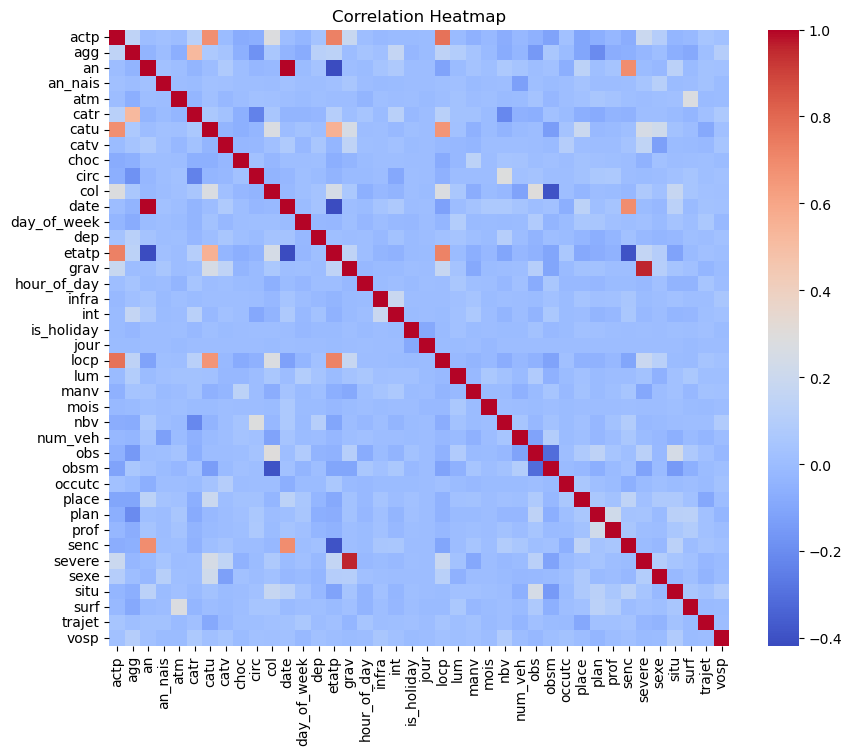

In [16]:
# Create a correlation matrix
correlation_matrix = df_numeric_scaled.corr()
plt.figure(figsize=(10, 8))
# Generate the heatmap
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')

# Add a title
plt.title('Correlation Heatmap')

# Display the plot
plt.show();

### Preparation of the training and test datasets
#### Split data
The dataset is split by year slides. We decided to drop the Covid-19 years 2020-21. The years 2005 to 2017 are selected for the train dataset and the years 2018 and 2019 for the test dataset. Furthermore, the `grav` variable is dropped because it is encoded in `severe`.


In [17]:
df.drop('grav', axis = 1, inplace = True)

In [18]:
# split the dataset to train and test data
X_train = df.loc[df['an'] < 2018]
X_train = X_train.drop('severe', axis = 1)

X_test = df[(df['an'] >= 2018) & (df['an'] < 2020)]
X_test = X_test.drop('severe', axis = 1)

y_train = df['severe'].loc[df['an'] < 2018]
y_test = df['severe'][(df['an'] >= 2018) & (df['an'] < 2020)]

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)


### Modelling the data using a Randon Forest classifier with 100 estimators

In [19]:
# run Randon Forest classifier for severe variable



from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Create a RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)

# Train the model using the training sets
clf.fit(X_train, y_train)

# Predict the target variable on the test set
y_pred = clf.predict(X_test)

# Get the accuracy score
acc = accuracy_score(y_test, y_pred)

# Model Accuracy, how often is the classifier correct?
print("[Random Forest Algorithm] Accuracy Score: {:.3f}".format(acc))

# Print the classification report
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_rep)


[Random Forest Algorithm] Accuracy Score: 0.778
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.72      0.74    111446
           1       0.79      0.82      0.80    140377

    accuracy                           0.78    251823
   macro avg       0.78      0.77      0.77    251823
weighted avg       0.78      0.78      0.78    251823



[Random Forest Algorithm] Accuracy Score: 0.776
Classification Report:

               precision    recall  f1-score   support

           0       0.76      0.73      0.74    111446

           1       0.79      0.81      0.80    140377

    accuracy                           0.78    251823

    macro avg       0.77      0.77      0.77    251823

    weighted avg   0.78      0.78      0.78    251823

In [20]:
from sklearn.metrics import confusion_matrix
#  confusion matrix
matrix = confusion_matrix(y_test, y_pred)  #y_test_preds

# Create a DataFrame from the confusion matrix
class_names = df.severe.values
dataframe = pd.DataFrame(matrix, index=['non-severe', 'severe'], 
                         columns=['severe-fatal', 'severe'])

# Display the confusion matrix as text
print("Confusion Matrix:")
print(dataframe)

Confusion Matrix:
            severe-fatal  severe
non-severe         80777   30669
severe             25201  115176


Length of feature_names: 38
Length of importances: 38


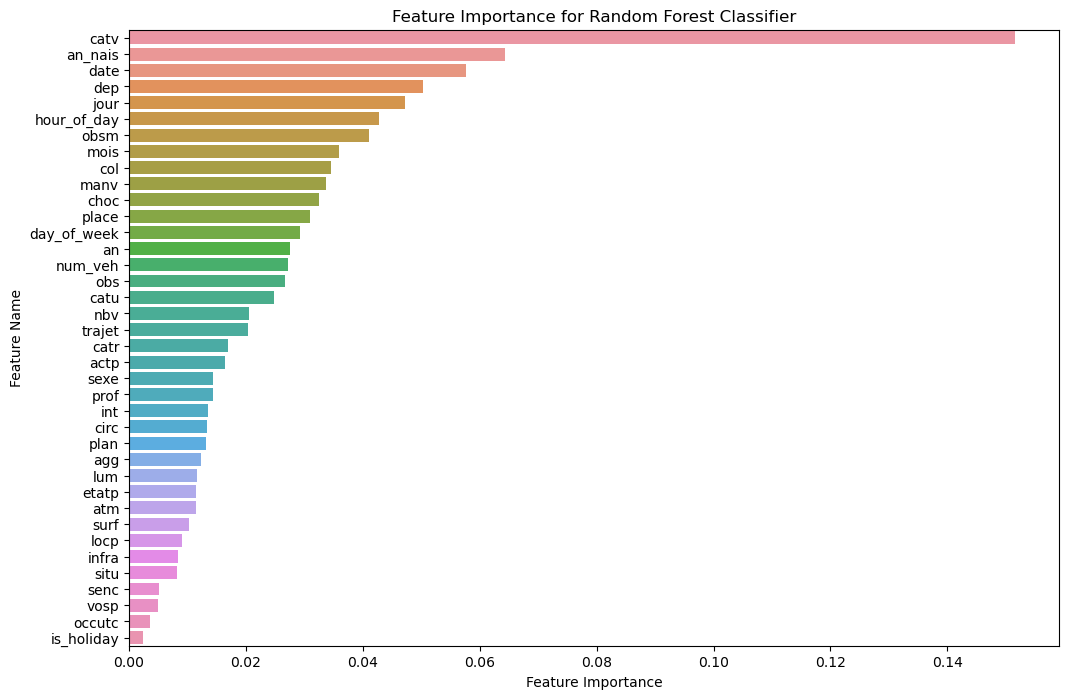

In [21]:
# estimate the feature impotance for the model
import numpy as np

# Access feature importances from the trained model
importances = clf.feature_importances_

feature_names = df.drop(columns=['severe']).columns.tolist()

# Check the lengths of feature_names and importances
print("Length of feature_names:", len(feature_names))
print("Length of importances:", len(importances))

# Create a DataFrame to hold feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot to visualize feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance for Random Forest Classifier')
plt.show()

In [22]:
from sklearn.model_selection import KFold, cross_val_score
# Perform cross-validation with F1 score
f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1_macro', cv=5, n_jobs=2)

# Print the F1 scores for each fold
print("F1 Scores (Cross-Validation):", f1_scores)

# Calculate and print the mean F1 score
mean_f1_score = f1_scores.mean()
print("Mean F1 Score (Cross-Validation):", mean_f1_score)

F1 Scores (Cross-Validation): [0.79074231 0.78746648 0.78958035 0.79317553 0.78486856]
Mean F1 Score (Cross-Validation): 0.7891666458794399


In [23]:
import joblib
joblib.dump(clf, 'random_forest_model_4b.pkl')

['random_forest_model_4b.pkl']